🚀 Predicting Customer Churn: A Comparative Modeling Approach

🎯 Project Goal: The primary objective of this project is to develop and compare multiple machine learning models to accurately predict whether a customer will churn (i.e., close their account) or continue their relationship with the company. The target variable is $\text{Exited}$ (a binary outcome), and the final output must be a probability score for each customer leaving.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt

**Data Loading and initial inspection**

In [2]:
df = pd.read_csv('train.csv')
df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15709511,Ch'ang,754,Spain,Male,40,8,102954.68,2,1,1,149238.35,0
1,1,15592761,Genovese,579,France,Female,28,1,0.00,2,1,0,64869.32,0
2,2,15579914,Yeh,744,France,Female,56,5,0.00,1,1,0,158816.03,1
3,3,15669611,Nwachinemelu,697,France,Male,29,2,0.00,2,1,0,55775.72,0
4,4,15761775,Hs?eh,628,France,Female,22,9,0.00,2,1,0,49653.39,0


**Data processing:**
  - remove irrelavant columns id, customerid, and surename
  - check na
  - check none-scense values in balance, estimated salary, and creditscore
  - check categorical values
  - convert string values into int (like Male to 0)
  - convert all values to numerical for later model training
  - set the independent (X) and dependent (y) variables
  - split them into train test split for validation



In [3]:
# Drop columns id, CustomerId, Surname
df = df.drop(['id', 'CustomerId', 'Surname'], axis=1)
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,754,Spain,Male,40,8,102954.68,2,1,1,149238.35,0
1,579,France,Female,28,1,0.00,2,1,0,64869.32,0
2,744,France,Female,56,5,0.00,1,1,0,158816.03,1
3,697,France,Male,29,2,0.00,2,1,0,55775.72,0
4,628,France,Female,22,9,0.00,2,1,0,49653.39,0


In [4]:
df.isna().sum()

,0
CreditScore,0
Geography,0
Gender,0
Age,0
Tenure,0
Balance,0
NumOfProducts,0
HasCrCard,0
IsActiveMember,0
EstimatedSalary,0


In [5]:
# Check and see if any negative values in balance, estimated salary, and creditscore
df[(df['Balance']<0)|(df['EstimatedSalary']<0)|(df['CreditScore']<0)]

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited


In [6]:
# Check and see if there is any abnormal situation in the categorical columns
for i in df.columns:
  if i != 'Balance' and i != 'EstimatedSalary' and i != 'CreditScore':
    df[i] = df[i].astype('category')
    print(f'{i}:{df[i].unique()}')

Geography:['Spain', 'France', 'Germany']
Categories (3, object): ['France', 'Germany', 'Spain']
Gender:['Male', 'Female']
Categories (2, object): ['Female', 'Male']
Age:[40, 28, 56, 29, 22, ..., 18, 70, 68, 65, 74]
Length: 56
Categories (56, int64): [18, 19, 20, 21, ..., 70, 71, 72, 74]
Tenure:[8, 1, 5, 2, 9, ..., 3, 6, 7, 0, 10]
Length: 11
Categories (11, int64): [0, 1, 2, 3, ..., 7, 8, 9, 10]
NumOfProducts:[2, 1, 3, 4]
Categories (4, int64): [1, 2, 3, 4]
HasCrCard:[1, 0]
Categories (2, int64): [0, 1]
IsActiveMember:[1, 0]
Categories (2, int64): [0, 1]
Exited:[0, 1]
Categories (2, int64): [0, 1]


In [7]:
# convert georgraphy and gender into numeric 0/1/2
df['Geography'] = df['Geography'].cat.codes
df['Gender'] = df['Gender'].cat.codes
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,754,2,1,40,8,102954.68,2,1,1,149238.35,0
1,579,0,0,28,1,0.00,2,1,0,64869.32,0
2,744,0,0,56,5,0.00,1,1,0,158816.03,1
3,697,0,1,29,2,0.00,2,1,0,55775.72,0
4,628,0,0,22,9,0.00,2,1,0,49653.39,0


In [8]:
# Looks all good and ready to next step
for i in df.columns:
  df[i] = pd.to_numeric(df[i], errors='coerce')
  #df[i] = df[i].astype('float64')
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      15000 non-null  int64  
 1   Geography        15000 non-null  int8   
 2   Gender           15000 non-null  int8   
 3   Age              15000 non-null  int64  
 4   Tenure           15000 non-null  int64  
 5   Balance          15000 non-null  float64
 6   NumOfProducts    15000 non-null  int64  
 7   HasCrCard        15000 non-null  int64  
 8   IsActiveMember   15000 non-null  int64  
 9   EstimatedSalary  15000 non-null  float64
 10  Exited           15000 non-null  int64  
dtypes: float64(2), int64(7), int8(2)
memory usage: 1.1 MB


In [9]:
df.isna().sum()

,0
CreditScore,0
Geography,0
Gender,0
Age,0
Tenure,0
Balance,0
NumOfProducts,0
HasCrCard,0
IsActiveMember,0
EstimatedSalary,0


In [10]:
# seperate the dependent and independent variables as y and X
X = df.drop('Exited', axis=1)
y = df['Exited']

In [11]:
# split the X,y into train test at 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Model training**

    - Grid Search will be used
    - Models to be trained: SVM, NB, RF, Ada, KNN, and LR
    - parameters will be the commonly used ones
    - cross validation n set to 5
    - performance socre used is F1 for the imbalanced y variable
    - used AUC to evaluate the performances for the models too (both show ada the best)
    

In [12]:
# 2. Define the Models and Parameter Grids ---

# The pipeline ensures that standardization is applied *inside* each cross-validation fold
# before the classifier is trained.

pipeline_svm = Pipeline([('scaler', StandardScaler()), ('svm', SVC(random_state=42))])
pipeline_nb = Pipeline([('nb', GaussianNB())]) # NB is generally scale-insensitive
pipeline_rf = Pipeline([('rf', RandomForestClassifier(random_state=42))])
pipeline_ada = Pipeline([('ada', AdaBoostClassifier(random_state=42))])
pipeline_knn = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])
pipeline_lr = Pipeline([('scaler', StandardScaler()), ('lr', LogisticRegression(random_state=42))])

In [13]:
# Define the parameter grids for each model
# Note: Parameters are prefixed with the model name from the pipeline (e.g., 'svm__C')

param_grid_svm = {
    'svm__C': [0.1, 1, 10],
    'svm__kernel': ['linear', 'rbf']
}

param_grid_nb = {} # Naive Bayes usually has no hyperparams to tune
# For Logistic Regression, scaling is added, and C is tuned.
param_grid_lr = {
    'lr__C': [0.1, 1, 10],
    'lr__solver': ['liblinear', 'lbfgs']
}

param_grid_rf = {
    'rf__n_estimators': [50, 100],
    'rf__max_depth': [None, 10]
}

param_grid_ada = {
    'ada__n_estimators': [50, 100],
    'ada__learning_rate': [0.5, 1.0]
}

param_grid_knn = {
    'knn__n_neighbors': [3, 5, 7],
    'knn__weights': ['uniform', 'distance']
}

# Combine all pipelines and grids into lists
pipelines = [
    ('SVM', pipeline_svm, param_grid_svm),
    ('NaiveBayes', pipeline_nb, param_grid_nb),
    ('RandomForest', pipeline_rf, param_grid_rf),
    ('AdaBoost', pipeline_ada, param_grid_ada),
    ('KNN', pipeline_knn, param_grid_knn),
    ('LogRegression', pipeline_lr, param_grid_lr)
]

In [14]:
best_models = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring_metric = 'f1' # y is imbalanced, cost is unknown, for a balanced measure, use F1 score

print(f"--- Starting Grid Search with {cv.n_splits}-fold Cross-Validation ---")
print(f"Optimizing for metric: {scoring_metric}\n")

for name, pipeline, param_grid in pipelines:
    print(f"Running GridSearchCV for: **{name}**")

    # Initialize GridSearchCV
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=cv,
        scoring=scoring_metric,
        n_jobs=-1, # Use all available cores
        verbose=0
    )

    # Fit the Grid Search to the training data
    grid_search.fit(X_train, y_train)

    # Store the best model and results
    best_models[name] = grid_search.best_estimator_

    print(f"  Best {name} Score (CV): {grid_search.best_score_:.4f}")
    print(f"  Best Parameters: {grid_search.best_params_}\n")

print("--- Grid Search Complete ---")
print("\n--- Evaluation on Test Set ---")

--- Starting Grid Search with 5-fold Cross-Validation ---
Optimizing for metric: f1

Running GridSearchCV for: **SVM**
  Best SVM Score (CV): 0.7073
  Best Parameters: {'svm__C': 10, 'svm__kernel': 'rbf'}

Running GridSearchCV for: **NaiveBayes**
  Best NaiveBayes Score (CV): 0.5052
  Best Parameters: {}

Running GridSearchCV for: **RandomForest**
  Best RandomForest Score (CV): 0.7149
  Best Parameters: {'rf__max_depth': None, 'rf__n_estimators': 100}

Running GridSearchCV for: **AdaBoost**
  Best AdaBoost Score (CV): 0.7194
  Best Parameters: {'ada__learning_rate': 1.0, 'ada__n_estimators': 100}

Running GridSearchCV for: **KNN**
  Best KNN Score (CV): 0.6704
  Best Parameters: {'knn__n_neighbors': 5, 'knn__weights': 'uniform'}

Running GridSearchCV for: **LogRegression**
  Best LogRegression Score (CV): 0.6124
  Best Parameters: {'lr__C': 0.1, 'lr__solver': 'lbfgs'}

--- Grid Search Complete ---

--- Evaluation on Test Set ---


**Evaluate and compare: AUC**

Based on the AUC performance report, AdaBoosting model has best performance.

In [15]:
print("\n--- Evaluation on Test Set with AUC ---")

final_results = {}

for name, model in best_models.items():
    print(f"Evaluating {name}...")

    # 1. get the predicted test values
    y_ = model.predict(X_test)
    # 2. Calculate ROC AUC
    test_auc = roc_auc_score(y_test, y_)
    final_results[name] = test_auc

    # 3. Print the result
    print(f"**{name} Final Test Results**")
    print(f"Test Set ROC AUC: {test_auc:.4f}\n")

print("\n--- Summary of ROC AUC Scores ---")
for name, auc in sorted(final_results.items(), key=lambda item: item[1], reverse=True):
    print(f"{name}: {auc:.4f}")


--- Evaluation on Test Set with AUC ---
Evaluating SVM...
**SVM Final Test Results**
Test Set ROC AUC: 0.8199

Evaluating NaiveBayes...
**NaiveBayes Final Test Results**
Test Set ROC AUC: 0.6561

Evaluating RandomForest...
**RandomForest Final Test Results**
Test Set ROC AUC: 0.8194

Evaluating AdaBoost...
**AdaBoost Final Test Results**
Test Set ROC AUC: 0.8236

Evaluating KNN...
**KNN Final Test Results**
Test Set ROC AUC: 0.7966

Evaluating LogRegression...
**LogRegression Final Test Results**
Test Set ROC AUC: 0.7243


--- Summary of ROC AUC Scores ---
AdaBoost: 0.8236
SVM: 0.8199
RandomForest: 0.8194
KNN: 0.7966
LogRegression: 0.7243
NaiveBayes: 0.6561


**Evaluate and compare: F1 score**

Based on the F1 performance report, AdaBoosting model has best performance too.

In [16]:
# Evaluate Best Models on the Test Set, all scores are shown, we focus on the F1 score(imbalanced y)
for name, model in best_models.items():
    y_pred = model.predict(X_test)

    print(f"\n**{name} Final Test Results**")
    # For a quick summary, use the classification report
    print(classification_report(y_test, y_pred, zero_division=0))


**SVM Final Test Results**
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      2413
           1       0.81      0.68      0.74       587

    accuracy                           0.91      3000
   macro avg       0.87      0.82      0.84      3000
weighted avg       0.90      0.91      0.90      3000


**NaiveBayes Final Test Results**
              precision    recall  f1-score   support

           0       0.86      0.96      0.91      2413
           1       0.66      0.36      0.46       587

    accuracy                           0.84      3000
   macro avg       0.76      0.66      0.68      3000
weighted avg       0.82      0.84      0.82      3000


**RandomForest Final Test Results**
              precision    recall  f1-score   support

           0       0.93      0.96      0.94      2413
           1       0.80      0.68      0.73       587

    accuracy                           0.90      3000
   macro avg       0.86     

**Load the predict data and make predictions with the chosen model**

In [17]:
df1 = pd.read_csv('test.csv')
df1.drop(['id', 'CustomerId', 'Surname'], axis=1, inplace=True)

In [18]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
dtypes: float64(2), int64(6), object(2)
memory usage: 781.4+ KB


In [19]:
df1['Geography'] = df['Geography'].astype('int64')
df1['Gender'] = df['Gender'].astype('int64')
df1.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,751,2,1,38,3,0.00,2,1,0,145558.42
1,711,0,0,43,2,143680.36,2,1,1,118188.15
2,592,0,0,40,4,0.00,2,1,1,36754.13
3,676,0,1,48,5,121629.22,1,1,0,122221.71
4,746,0,0,36,5,0.00,2,1,1,97468.44


In [20]:
chosen = best_models['AdaBoost']
pred = chosen.predict(df1)
# counts of 0 and 1 in pred and all the output values
print(np.unique(pred, return_counts=True))
print(f"The predicted outcomes: {pred}")

(array([0, 1]), array([8448, 1552]))
The predicted outcomes: [0 0 0 ... 0 0 0]


**Feature Imoportance for the chosen model**

In [23]:
# feature importance for our best model
importances = chosen.named_steps['ada'].feature_importances_
feature_names = X_train.columns
feature_importances = pd.Series(importances, index=feature_names)
sorted_importances = feature_importances.sort_values(ascending=False)
print("--- AdaBoost Feature Importances ---")
print(sorted_importances)

--- AdaBoost Feature Importances ---
Age                0.377747
NumOfProducts      0.362276
Geography          0.102720
IsActiveMember     0.045388
Balance            0.037891
Gender             0.034255
EstimatedSalary    0.017592
CreditScore        0.012736
HasCrCard          0.005736
Tenure             0.003658
dtype: float64


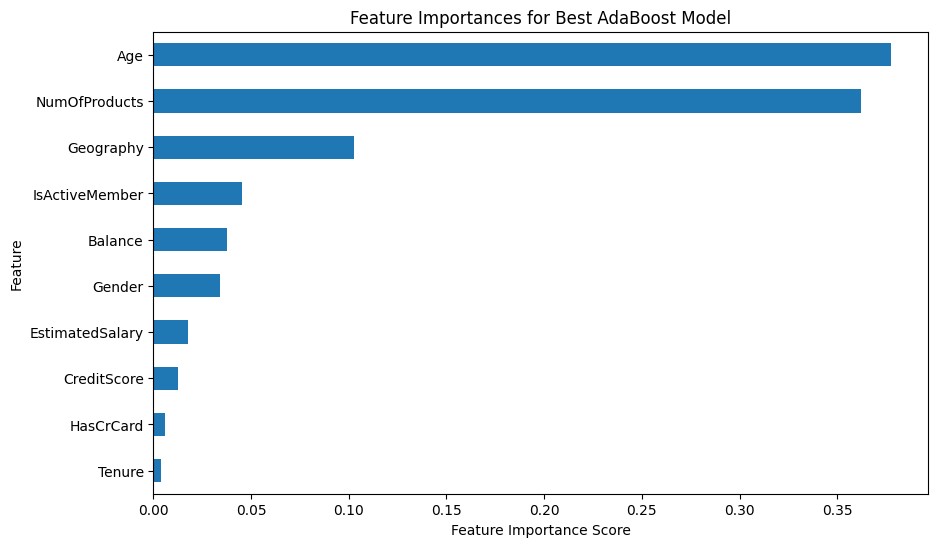

In [24]:
# Data visualizaiton for top important features - it gives direction for the the bank
plt.figure(figsize=(10, 6))
sorted_importances.plot(kind='barh')
plt.title('Feature Importances for Best AdaBoost Model')
plt.xlabel('Feature Importance Score')
plt.ylabel('Feature')
plt.gca().invert_yaxis() # Highest importance at the top
plt.show()